In [1]:
# import libraries
import math
import scipy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.integrate as integrate

%matplotlib inline
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# constants in SI
m = 9.10938291E-31 # mass of electron
q = 1.60217657E-19 # charge of electron
eV = 1.60217657E-19 # 1 electron volt in joules
ε = 8.85418782E-12 # permittivity of free space
h = 6.62606957E-34 # planck number
h_ev = 4.135667662E-15 #Plank number eV.s
hbar = 1.054571800E-34 # reduced planck constant
Rydberg = 2.1787E-18 # Rydberg energy (in joules)
avogadro = 6.02214179E23
c = 299792458 # m/s
sigma_ev = 3.54E11 #ev/m^2/s/K^4
sigma = 5.670367E-8 #J/m^2/s/K^4
# units in SI
Å = 1E-10 # m to angstrom
k = 1.38064852E-23 #J/K
k_ev = 8.6173303E-5 #ev/K

In [3]:
#materials parameters
E_g_ev = 1.57 #1.52 #for instance, WSe2 in eV
E_g = E_g_ev*eV
m_c = 0.1*m #conduction band effective mass
m_v = 0.1*m #valence band effective mass



In [4]:
#use AM 1.5 for 1 sun concentration (ASTMG173 global spectrum from 'American Society for Testing and Materials (ASTM) Terrestrial Reference Spectra for Photovoltaic Performance Evaluation')

wavelength, spectral_irr_w = np.genfromtxt('ASTMG173.csv', delimiter=',').T #spectral irradience (W/m^2/nm-1)
E_data = h*c/(wavelength*1E-9) # convert wavelength to energy including jacobian transform

spectral_irr = spectral_irr_w*1E9*h*c/((E_data)**2) #W/m^2J -include jacobian transform


In [5]:
E = np.linspace(E_data[-1],E_data[0],501)
w_nm = 1240/(E/eV)

In [6]:
spec_interp = interp1d(E_data[::-1], spectral_irr[::-1])
spec = spec_interp(E)
AM1p5_photon_number = spec/E

Or, can model light incident on solar cell as black body at at 5760 Kelvin), the incoming particle flux is given by:

$F_{a} = \int_{E_{g}}^{\infty} \frac{2F_{s}}{h^{3}c^{2}}\frac{E^{2}dE}{e^{ E/kT_{s}}-1}$

(This is the number density of photons coming from the sun, not the energy density)

In [7]:
T_s = 5760 #K
F_s = 2.16e-5*np.pi # blackbody normalisation to 1000W/m^2, solid angle of light from sun 

In [10]:
#In eV, black body energy density spec looks like..(spectra from Nelson, and other papers)
w = w_nm*1e-9
bb_spec_Nelson = (2*F_s*E**3)/(h**3*c**2*(np.exp(E/(k*T_s))-1))
bb_spec_Nelson_w = 2*F_s*(h*c**2/w**5)*(1/(np.exp((h*c)/(k*T_s*w))-1)) # in wavelength

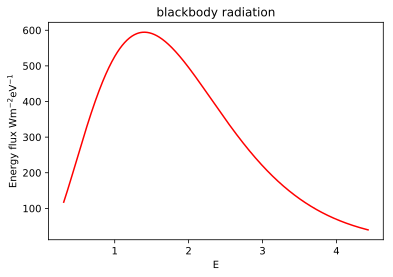

In [11]:
fig = plt.figure()
ax=fig.add_subplot(111, label="1")

ax.plot(E/eV, eV*bb_spec_Nelson, 'r')
ax.set_xlabel('E')
ax.set_ylabel('Energy flux W$\mathregular{m^{-2}eV^{-1}}$')
ax.set_title('blackbody radiation')

plt.show()

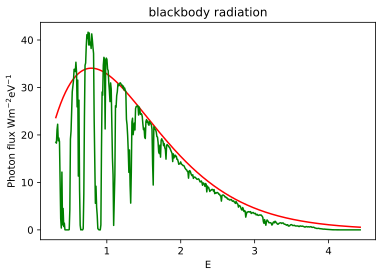

In [12]:
fig = plt.figure()
ax=fig.add_subplot(111, label="1")

ax.plot(E/eV, 1e-20*eV*bb_spec_Nelson/(E), 'r')
ax.plot(E/eV, 1e-20*eV*spec/(E), 'g')
ax.set_xlabel('E')
ax.set_ylabel('Photon flux W$\mathregular{m^{-2}eV^{-1}}$')
ax.set_title('blackbody radiation')

plt.show()

In [13]:
wavelength_0, spectral_irr_w_0 = np.genfromtxt('AM1p0.csv', delimiter=',').T #spectral irradience (W/m^2/nm-1)
E_data_0 = h*c/(wavelength_0*1E-9) # convert wavelength to energy including jacobian transform

spectral_irr_0 = spectral_irr_w_0*1E9*h*c/((E_data_0)**2) #W/m^2J -include jacobian transform

spec_interp_0 = interp1d(E_data_0[::-1], spectral_irr_0)
spec_0 = spec_interp_0(E[E>=E_g])


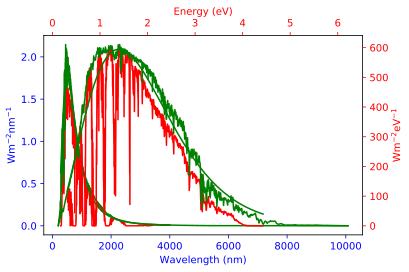

In [14]:
#plot Am1.5, AM1.0, and black body radiation in energy and wavelength

fig=plt.figure()
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)

ax.plot(wavelength, spectral_irr_w, color='r')
ax.plot(wavelength_0, spectral_irr_w_0, color='g')
ax.plot(w_nm, 1e-9*bb_spec_Nelson_w, color='g')
ax.set_xlabel('Wavelength (nm)', color='b')
ax.set_ylabel('W$\mathregular{m^{-2}nm^{-1}}$',color='b')
ax.tick_params('x', colors='b')
ax.tick_params('y', colors='b')

ax2.plot(E_data/eV, spectral_irr*eV, color='r')
ax2.plot(E_data_0/eV, spectral_irr_0*eV, color='g')
ax2.plot(E/eV, eV*bb_spec_Nelson, 'g')
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_ylabel('W$\mathregular{m^{-2}eV^{-1}}$',  color='r')
ax2.set_xlabel('Energy (eV)', color='r')
ax2.tick_params('x', colors='r')
ax2.tick_params('y', colors='r')
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 



fig.tight_layout()
plt.show()


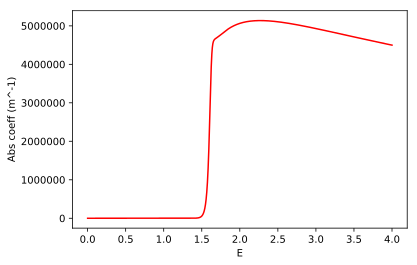

In [15]:
#calculate absorbed photons
#load absorption coefficient
energy_data, abs_coeff_perov_uncor = np.genfromtxt('perovskite_abs_coeff.csv', delimiter=',').T
abs_coeff_perov = abs_coeff_perov_uncor/2

spec_interp = interp1d(E_data[::-1], spectral_irr[::-1])
spec = spec_interp(E)

fig = plt.figure()
ax=fig.add_subplot(111, label="1")

ax.plot(energy_data, abs_coeff_perov, 'r')
ax.set_xlabel('E')
ax.set_ylabel('Abs coeff (m^-1)')

plt.show()

#Set thickness
l = 200e-9 #thickness in meters

abs_coeff = abs_coeff_perov
absorbance = abs_coeff*l


In [ ]:
N_tot = absorbance*

In [12]:
#carrier temperature (insert rate equation here)
T_c = 500 #K

In [13]:
#calculate number of electrons in conduction band - based on F_a
N = 1E24
#holes in valence band
P = 1E24

In [14]:
#calculate quasi fermi levels from Nilsson approximation, cite Bennett, Soref, Alamo 1990

In [15]:
N_c = 2*(2*np.pi*m_c*k*T_c/(h**2))**(3/2)
N_v = 2*(2*np.pi*m_v*k*T_c/(h**2))**(3/2) #effective densities of states in conduction and valence band

In [16]:
#Nilsson approx
Mu_c = k*T_c*(np.log(N/N_c)+(N/N_c)*(64+0.05524*(N/N_c)*(64+(N/N_c)**(1/2))**(-1/4)))
Mu_v = k*T_c*(-1*(np.log(P/N_v)+(P/N_v)*(64+0.05524*(P/N_v)*(64+(P/N_v)**(1/2))**(-1/4)))-E_g)

In [17]:
Delta_mu = Mu_c-Mu_v
print(Mu_c/eV, Mu_v/eV, Delta_mu/eV)


1.59225617762 -1.59225617762 3.18451235525


outgoing radiation is given by
$F_{b} = \int_{E_{g}}^{\infty} \frac{2\pi}{h^{3}c^{2}}\frac{E^{2}dE}{e^{(E-\Delta\mu)/kT_{C}}-1}$

In [ ]:
F_b = np.trapz(E[E>E_g],2*pi/(h**3c**2)*(E[E>E_g]**2/(np.exp((E[E>E_g]-Delta_mu)/(k*T_c))-1))